In [1]:
import numpy as np
from scipy.optimize import minimize,basinhopping
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm

## General Chemical vs Electric propulsion curve

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


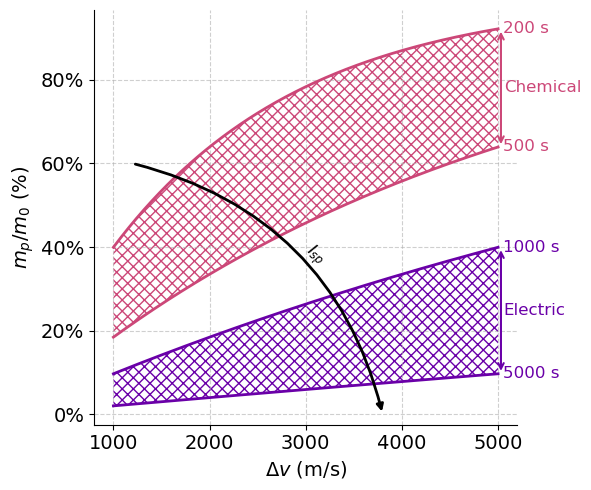

In [27]:
# Data arrays
delta_v     = np.linspace(1000, 5000, 401)
labels      = np.array(["200 s", "500 s", "1000 s", "5000 s"])
isp_values  = np.array([200, 500, 1000, 5000])
g0          = 9.80665  # m/s²

# Pick two colors: chemical (<500 s) vs electric (>=500 s)
cmap        = cm.plasma(np.linspace(0.5, 0.2, 2))
c_chem, c_elec = cmap

# Compute propellant mass fractions
fractions = {
    label: (1 - np.exp(-delta_v / (g0 * Isp))) * 100
    for label, Isp in zip(labels, isp_values)
}

# Create plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot each curve
for label, Isp in zip(labels, isp_values):
    color = c_chem if Isp <= 500 else c_elec
    frac  = fractions[label]
    ax.plot(delta_v, frac, lw=2.0, color=color)

# Hatch area between the two chemical curves (200 s & 500 s)
ax.fill_between(
    delta_v,
    fractions["500 s"],
    fractions["200 s"],
    facecolor='none',
    hatch='xxx',
    edgecolor=c_chem,
    linewidth=0
)

# Hatch area between the two electric curves (1000 s & 5000 s)
ax.fill_between(
    delta_v,
    fractions["5000 s"],
    fractions["1000 s"],
    facecolor='none',
    hatch='xxx',
    edgecolor=c_elec,
    linewidth=0
)

# Inline labels at the end of each curve
for label, Isp in zip(labels, isp_values):
    color = c_chem if Isp <= 500 else c_elec
    frac  = fractions[label]
    x0, y0 = delta_v[-1], frac[-1]
    ax.text(x0 + 50, y0, label, color=color,
            fontsize=12, va='center', ha='left')


# after you've computed `fractions` and before plt.tight_layout():

# pick an x‐location for the arrows
x0 = 5030
# find the nearest index in delta_v
ix = np.argmin(np.abs(delta_v - x0))

# y‐values on the two chemical curves
y1_chem = fractions["200 s"][ix]
y2_chem = fractions["500 s"][ix]

# draw a vertical double arrow between them
ax.annotate(
    "",
    xy=(x0, y1_chem),
    xytext=(x0, y2_chem),
    arrowprops=dict(arrowstyle='<->', lw=1.5, color=c_chem)
)
# optional label on arrow
ax.text(x0+30, 0.5*(y1_chem+y2_chem), "Chemical", color=c_chem, fontsize=12, va='center')

# now the electric pair
y1_ele = fractions["1000 s"][ix]
y2_ele = fractions["5000 s"][ix]

ax.annotate(
    "",
    xy=(x0, y1_ele),
    xytext=(x0, y2_ele),
    arrowprops=dict(arrowstyle='<->', lw=1.5, color=c_elec)
)
ax.text(x0+30, 0.5*(y1_ele+y2_ele), "Electric", color=c_elec, fontsize=12,va='center')









ax.annotate(
    "", 
    xy=(3800, 0),      # tail of arrow
    xytext=(1200,60),   # head of arrow
    arrowprops=dict(
        arrowstyle='-|>', 
        color='k', 
        lw=2,
        connectionstyle='arc3,rad=-0.3'               # negative rad bends the other way
    )
)
# label along the curve
ax.text(
    3100,               # x position halfway
    38,                 # y position (tweak as needed)
    "$I_{sp}$", 
    fontsize=12, 
    rotation=-40,       # align roughly with the arrow
    va='center', 
    ha='center'
)











# Formatting
ax.set_xlabel(r'$\Delta v$ (m/s)', fontsize=14)
ax.set_ylabel(r'$m_p/m_0$ (%)', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig("figures/electric/elecvschem.eps",bbox_inches='tight')

plt.show()

## Calculation with refueling considerations

In [39]:
# Function definitions
def payload_i (x,y,beta_i):
    Hi=np.exp(-beta_i *y/x) -x**2 *(1-np.exp(-y/x))
    return Hi


def payload_mission(x,y,sequence):
    H_list=[]
    for beta_i in sequence:
        H_list.append(payload_i(x,y,beta_i))
    Hm=np.min(H_list)
    return Hm


def time_coeff (x,y,sequence):
    mp_refuel= np.sum(1-np.exp(-sequence *y/x))
    mp_star=1-np.exp(-y/x)
    tau=mp_refuel/mp_star
    return tau


def specific_fuel_cons(x,y,sequence):
    mp_refuel= np.sum(1-np.exp(-sequence *y/x))
    Hm=payload_mission(x,y,sequence)
    f=mp_refuel/Hm
    return f



def jacobian_tau(x,y,sequence):
    return (y/x)/(1-np.exp(-y/x))*np.exp(-sequence*y/x) 

import numpy as np

def jacobian_payload(x, y, sequence):
    j = np.argmax(sequence)
    jacobian = np.zeros_like(sequence)
    jacobian[j] = - (y / x) * np.exp(-sequence[j] * y / x)
    
    return jacobian


# Optimization of $H_m$ as a function of $n$

In [40]:
def opt_H(x,y,n):
    return np.exp(-(1/n) *y/x) -x**2 *(1-np.exp(-y/x))

def opt_G(x,y,n,K):
    return np.exp(-(1/n) *y/x) -x**2 *(1-np.exp(-y/x)) - K*(1-np.exp(-(1/n) *y/x))

def mass_tank(x,y,n,K):
    return  (1+K)*(1-np.exp(-(1/n) *y/x))

def H_infty(x,y):
    return 1 -x**2 *(1-np.exp(-y/x))

In [41]:
y=0.8
x=0.6
K=0 #Tankage fraction - set to 0 for this work

n=np.arange(1,51,0.5)
H_opt=opt_H(x,y,n)
G_opt=opt_G(x,y,n,K)
m_tank=mass_tank(x,y,n,K)
limit_H=H_infty(x,y)
limit_H

0.7348949697216616

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


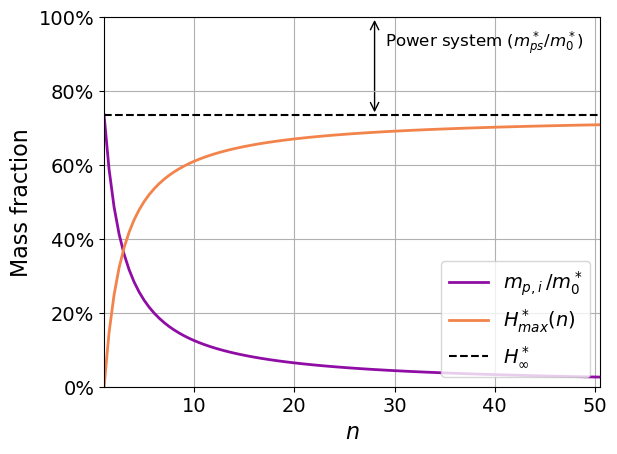

In [42]:
fig=plt.plot(figsize=(8,8),dpi=150)

colors = cm.plasma(np.linspace(0.3, 0.7, 2))


plt.plot(n,m_tank,color=colors[0],lw=2,label=rf"$m_{{p,i}}\,/m_0^*$")
plt.plot(n,H_opt,color=colors[-1],lw=2,label=rf"$H^*_{{max}}(n)$")
plt.plot(np.array([n[0],n[-1]]),np.array([limit_H,limit_H]),"--k",label=rf"$H^*_{{\infty}}$")

#plt.xlabel(r'$n$: number of mission segments',fontsize=16)  
plt.xlabel(r'$n$',fontsize=16) 
plt.ylabel(r'Mass fraction',fontsize=16)   
plt.xlim([1,n[-1]])
plt.ylim([0,1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))


# Add the double arrow at a specific location
start_point = (28, 1)  # Set the start point of the double arrow
end_point = (28, limit_H)    # Set the end point of the double arrow
arrow = FancyArrowPatch(start_point, end_point, arrowstyle='<->',lw=1, mutation_scale=15, color='k')
plt.gca().add_patch(arrow)

# Add the text label for the double arrow
plt.text(39, 0.89, r"Power system ($m_{ps}^*/m_0^*$)", ha='center', va='bottom', color='k', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.legend(loc="lower right",fontsize=14)
plt.savefig("figures/electric/H_vs_n.eps",bbox_inches='tight')

## Optimal specific impulse c

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


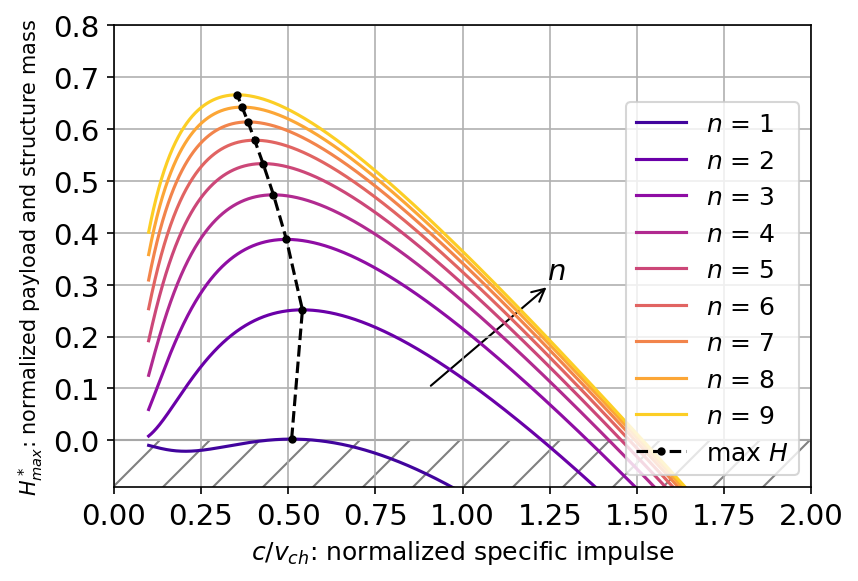

In [43]:
y=0.8
x_vec=np.arange(.1,2,0.001)
n_vec=np.arange(1,10,1)

max_H=[]
opt_x=[]

colors = cm.plasma(np.linspace(0.1, 0.9, len(n_vec)))


plt.figure(figsize=(6, 4), dpi=150)


for i, n in enumerate(n_vec):
    H_opt_old=opt_H(x_vec,y,n)
    max_H.append(np.max(H_opt_old))
    opt_x.append(x_vec[np.argmax(H_opt_old)])
        
    plt.plot(x_vec,H_opt_old,color=colors[i],label=f"$n$ = {n}")
    
plt.plot(opt_x,max_H,"k.--",label=f"max $H$")
    
    
aa=np.array([-1,-1])
plt.fill_between(np.array([0,2]), aa, where=(aa < 0), color='none', edgecolor='gray', hatch='/', interpolate=True)


start_point = (0.90, 0.1)  # Set the start point of the double arrow
end_point = (1.25, 0.3)    # Set the end point of the double arrow
arrow = FancyArrowPatch(start_point, end_point, arrowstyle='->',lw=1, mutation_scale=15, color='k')
plt.gca().add_patch(arrow)
plt.text(1.27, 0.30, r"$n$", ha='center', va='bottom', color='k', fontsize=14)
 
plt.xlim([0,2])
plt.ylim([-.09,.8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$c/v_{ch}$: normalized specific impulse',fontsize=12)  
plt.ylabel('$H^*_{max}$: normalized payload and structure mass',fontsize=10) 



plt.legend(loc="lower right",fontsize=12)  
plt.grid(True)
plt.savefig("figures/electric/HvsC_refueling.eps",bbox_inches='tight')



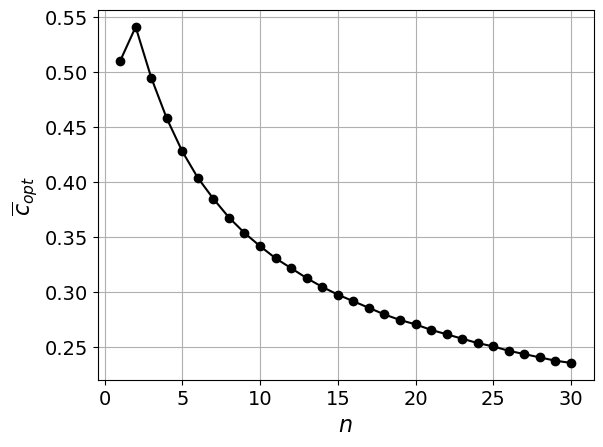

In [44]:
y=0.8
x_vec=np.arange(.01,2,0.001)
n_vec=np.arange(1,31,1)



max_H=[]
opt_x=[]
for n in n_vec:
    H_opt=opt_H(x_vec,y,n)
    max_H.append(np.max(H_opt))
    opt_x.append(x_vec[np.argmax(H_opt)])
        
   
plt.plot(n_vec,opt_x,"ko-",lw=1.5)
#plt.xlabel('$n$: number of mission segments',fontsize=12) 
#plt.ylabel('$(c/v_{ch})_{opt}$: optimal normalized specific impulse',fontsize=12)   

plt.xlabel('$n$',fontsize=16) 
plt.ylabel(r'$ \overline{c}_{opt}$',fontsize=16) 


plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/electric/optc_vsn.eps",bbox_inches='tight')

<Figure size 1000x600 with 0 Axes>

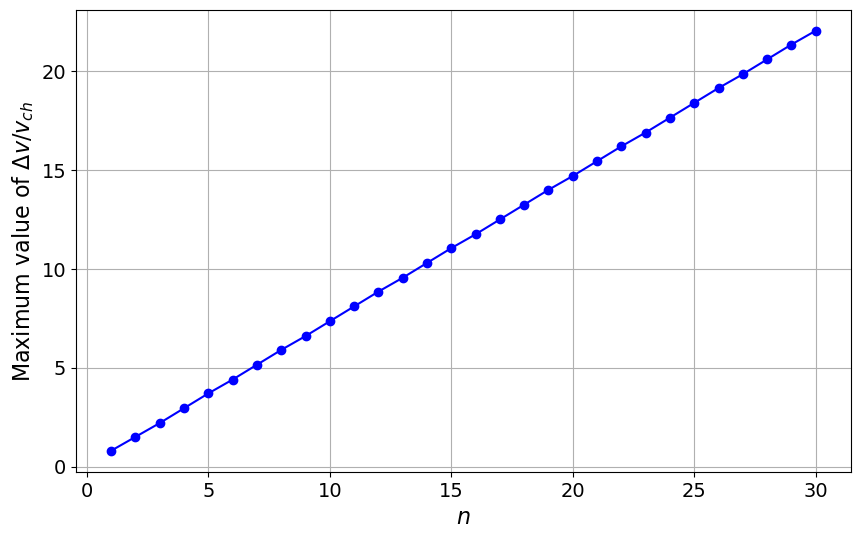

In [45]:
y_vec=np.arange(0,25,0.05)
x_vec=np.arange(.1,2,0.001)
n_vec=np.arange(1,31,1)


y_closest_to_zero = {}

for n in n_vec:
    max_H=[]
    for y in y_vec:
        H_opt_old=opt_H(x_vec,y,n)
        max_H.append(np.max(H_opt_old)) 
    # Find the r1 value where H is closest to 0
    closest_index = np.argmin(np.abs(max_H))
    y_closest_to_zero[n] = y_vec[closest_index]
    
    
 # Plot r1_closest_to_zero vs beta
fig=plt.figure(figsize=(10,6)) 
n = list(y_closest_to_zero.keys())
y_vals = list(y_closest_to_zero.values())

plt.figure(figsize=(10, 6))
plt.plot(n, y_vals, 'ob-')
#plt.xlim([0,1.01])

plt.xlabel(r'$n$',fontsize=16)
plt.ylabel(r'Maximum value of $\Delta v/v_{ch}$',fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig("figures/electric/max_delv.png")

plt.show()

# Optimization of $\tau$ as a function of $n$

In [46]:
y=.8
x=.6
n=np.arange(1,41,1)

In [47]:
def max_tau(x,y,n):
    return n*(1-np.exp(-(1/n)*y/x))/(1-np.exp(-y/x))

def analytical_lim_tau(x,y):
    return y/x/(1-np.exp(-y/x))

In [48]:
tau_max=max_tau(x,y,n)
limit_tau=analytical_lim_tau(x,y)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


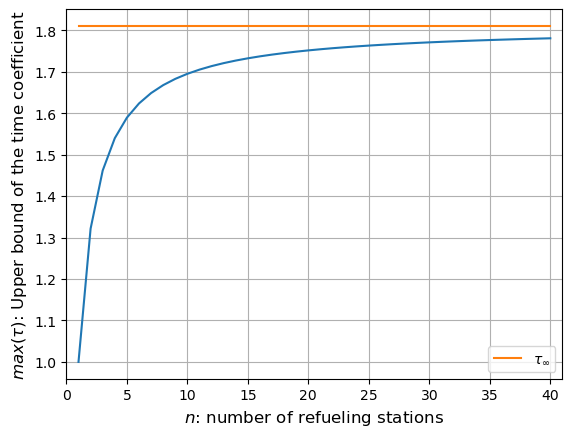

In [49]:
fig=plt.plot(figsize=(8,8))
plt.plot(n,tau_max)
plt.plot(np.array([n[0],n[-1]]),np.array([limit_tau,limit_tau]),label=r"$\tau_{\infty}$")

plt.xlabel(r'$n$: number of refueling stations',fontsize=12)  
plt.ylabel(r'$max(\tau)$: Upper bound of the time coefficient',fontsize=12)   
plt.xlim([0,n[-1]+1])
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig("figures/electric/tau_vs_n.eps",bbox_inches='tight')

# SMART1 mission

In [50]:
# Reported values
mpay=18.9 #kg
mp=82 #kg
mps=96.3 #kg
ms=169.7 #kg
m0=366.9 #kg
P=1190 #W
isp=1640 #s
thrust= 68*1e-3 #N 
delv=3900 #m/s
time= 7 # months


# Calculated values
H= (mpay+ms)/m0 ;    print("H=",H)
f= mp/(mpay+ms);     print("f=",f)
tf= time*30*24*3600; print("tf=",tf)
c= isp*9.81; print("c=",c)
mdot=thrust/c ; print("mdot=",mdot)
Pjet= 0.50*thrust*c ;   print("Pjet=",Pjet)
eta= Pjet/P ;   print("eta=",eta)
alpha=mps/P  ;   print("alpha=",alpha)
vch=np.sqrt(2*eta*tf/alpha); print("vch=",vch)
y=delv/vch; print("y=",y)
x=c/vch; print("x=",x)
print("___________________________")
H_th=opt_H(x,y,1);    print("H_th=",H_th)
H_inf=H_infty(x,y) ; print("H_inf=",H_inf)
tau_inf=analytical_lim_tau(x,y) ; print("tau_inf=",tau_inf)

H= 0.5140365222131371
f= 0.43478260869565216
tf= 18144000
c= 16088.400000000001
mdot= 4.226647771064867e-06
Pjet= 547.0056000000001
eta= 0.4596685714285715
alpha= 0.08092436974789916
vch= 14357.018470576892
y= 0.2716441444992646
x= 1.1205947831697356
___________________________
H_th= 0.5144170817608917
H_inf= 0.7296832456610532
tau_inf= 1.1260974627669385


# Optimization under constraints

In [51]:
# Constraint functions

def constraint_sum_beta(sequence):
    return np.sum(sequence) - 1

def constraint_payload_min(x, y, sequence, H_min):
    return payload_mission(x, y, sequence) - H_min

def constraint_tau_max(x, y,sequence, tau_max):
    return tau_max - time_coeff(x, y, sequence)

def constraint_f_max( x, y,sequence, f_max):
    return f_max - specific_fuel_cons(x, y, sequence)

### Maximize H under constraints. 

In [56]:
y=0.27
x=1.10

n = 10

H_max=opt_H(x,y,n)
H_inf=H_infty(x,y)

theoretical_max_tau=max_tau(x,y,n)
limit_tau=analytical_lim_tau(x,y)

tau_max = 1.1


print("H_(n=10)", H_max)
print("H_inf=", H_inf)
print("tau_(n=10)", theoretical_max_tau)
print("tau_inf=", limit_tau)
print("____________________")
print("Constraint: tau_max=",tau_max)



beta_initial = np.random.rand(n)
beta_initial= beta_initial/np.sum(beta_initial)
bounds = [(0, 1)] * n

H_(n=10) 0.7123954370859146
H_inf= 0.7366421015998724
tau_(n=10) 1.1140149674688773
tau_inf= 1.127742899697502
____________________
Constraint: tau_max= 10


In [57]:
# Constraints with parameters, including constraint_tau_max
constraints = [
    {'type': 'eq', 'fun': constraint_sum_beta},
    {'type': 'ineq', 'fun': lambda beta: constraint_tau_max(x, y, beta, tau_max)},  
]


# Set up the minimizer kwargs with Jacobian and options for basinhopping
minimizer_kwargs = {
    'method': 'SLSQP',  # Using SLSQP for constraints
    'jac': lambda beta: -jacobian_payload(x, y, beta),  # Negative Jacobian for maximization
    'constraints': constraints,
    'bounds': bounds,
    'options': {
        'maxiter': 1000,
        'disp': False,
        'ftol': 1e-6
    }
}

# Perform the basinhopping optimization for maximization
result = basinhopping(
    lambda beta: -payload_mission(x, y, beta),  # Negative for maximization
    beta_initial,  # Initial guess
    minimizer_kwargs=minimizer_kwargs,  # Local optimizer settings with Jacobian and options
    niter=200,  # Number of iterations for basinhopping
    stepsize=0.05,  # Step size for random hopping
    T=0.1,  # Temperature for accepting worse solutions
    disp=False  # Display progress
)


if result.success:
    print("success")
else:
    print("Failure")
    



print(f"Optimal sequence: {[f'{beta:.3f}' for beta in np.sort(result.x)[::-1]]}")
print(f"Payload mission: {payload_mission(x, y, result.x):.3f}")
print(rf"Percentage of $H_{{inf}}$: {100*payload_mission(x, y, result.x)/H_inf:.3f}%")
print(f"Time coeff: {time_coeff(x, y, result.x):.3f}")
print(f"Specific fuel cons: {specific_fuel_cons(x, y, result.x):.3f}")

success
Optimal sequence: ['0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100']
Payload mission: 0.712
Percentage of $H_{inf}$: 96.708%
Time coeff: 1.114
Specific fuel cons: 0.340


### Test convergence

In [17]:
iterations=50
results=[]
for i in range(iterations):
    beta_initial = np.random.rand(n)
    beta_initial= beta_initial/np.sum(beta_initial)
    
    result = basinhopping(
    lambda beta: -payload_mission(x, y, beta),  # Negative for maximization
    beta_initial,  # Initial guess
    minimizer_kwargs=minimizer_kwargs,  # Local optimizer settings with Jacobian and options
    niter=20,  # Number of iterations for basinhopping
    stepsize=0.05,  # Step size for random hopping
    T=0.1,  # Temperature for accepting worse solutions
    disp=False  # Display progress
)
    results.append(-result.fun)
    

(0.0, 1.0)

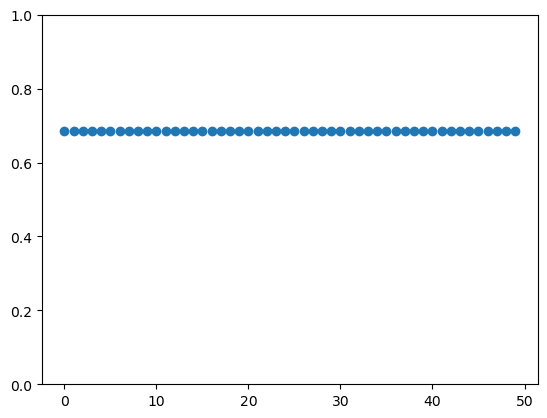

In [18]:
plt.scatter(np.arange(0,np.size(results)),results)
plt.ylim([0,1])

# Summary of optimization

In [2]:
n_vec=np.array([1,2,3,10])
H_vec=np.array([101,103,113,120])
tau_vec=np.array([100,102,108,110])
f_vec=np.array([99,98,93,91])

n_labels = ['n=1', 'n=2', 'n=3', 'n=10']

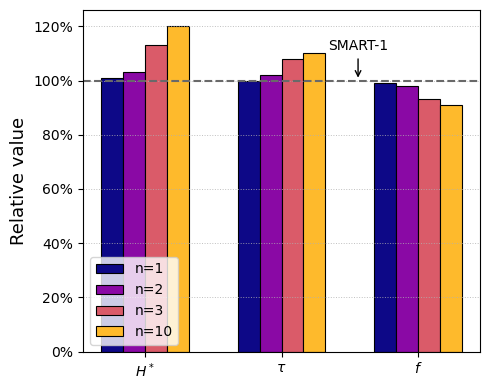

In [11]:
# Combine data for grouped bar plot
metrics = [r'$H^*$', r'$\tau$', r'$f$']
data = [H_vec, tau_vec, f_vec]

# Colors
colors = cm.plasma(np.linspace(0, 0.85, len(n_labels)))

# Parameters
bar_width = 0.08
spacing_factor = 0.08
x = np.arange(len(metrics)) * 0.5  # Reduce group spacing from default of 1.0

# Plot
plt.figure(figsize=(5, 4))
for i in range(len(n_labels)):
    plt.bar(
        x + (i - 1.5) * spacing_factor,
        [metric[i] for metric in data],
        width=bar_width,
        label=n_labels[i],
        color=colors[i],
        edgecolor='k',       # Dark border
        linewidth=0.8      
    )

# Reference line
plt.axhline(100, color='dimgray', linestyle='--')

plt.annotate(
    'SMART-1',
    xy=(.78, 100),             # Arrow tip (in data coordinates)
    xytext=(.78, 110),         # Text position (above the line)
    textcoords='data',
    arrowprops=dict(arrowstyle='->', color='black', lw=1),
    ha='center',
    va='bottom',
    fontsize=10
)

# Formatting
plt.xticks(x, metrics)
plt.ylabel(r'Relative value',fontsize=13)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.legend(loc='lower left')

plt.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.8)

plt.tight_layout()

plt.savefig("figures/barplot_metrics.pdf", format='pdf', bbox_inches='tight')


plt.show()